In [119]:
import sympy.interactive
sympy.interactive.init_printing('mathjax')

In [2]:
import sys
sys.path.append('/home/bnijholt/orbitalfield/')

In [3]:
%matplotlib inline

In [43]:
# %%px --local
# 1. Standard library imports
import os.path
from math import pi
from itertools import product
# 2. External package imports
import kwant
import types
import sympy
from sympy.physics.quantum import TensorProduct as kr
import numpy as np
import holoviews as hv
import scipy.sparse.linalg as sla
from scipy.constants import hbar, m_e, eV, physical_constants
# 3. Internal imports
from discretizer import Discretizer, momentum_operators
import current
hv.notebook_extension()
sx, sy, sz = [sympy.physics.matrices.msigma(i) for i in range(1, 4)]
s0 = sympy.eye(2)

# Parameters taken from arXiv:1204.2792
# All constant parameters, mostly fundamental constants, in a SimpleNamespace.
constants = types.SimpleNamespace(
    m=0.015 * m_e,  # effective mass in kg
    a=10,  # lattice spacing in nm
    g=50,  # Lande factor
    hbar=hbar,
    m_e=m_e,
    e=eV,
    eV=eV,
    meV=eV * 1e-3)

constants.t = (hbar ** 2 / (2 * constants.m)) * (1e18 / constants.meV)  # meV * nm^2
constants.mu_B = physical_constants['Bohr magneton'][0] / constants.meV

def hops(func):
    return lambda site1, site2, phase, p: func(site1, site2, p)

def onsite(func):
    return lambda site, phase, p: func(site, p)

def make_params(alpha=20,
                B_x=0,
                B_y=0,
                B_z=0,
                Delta=0.25,
                mu=0,
                orbital=True,
                A_correction=True,
                t=constants.t,
                g=constants.g,
                mu_B=constants.mu_B,
                V=lambda x,y,z: 0,
                **kwargs):
    """Function that creates a namespace with parameters.

    Parameters:
    -----------
    alpha : float
        Spin-orbit coupling strength in units of meV*nm.
    B_x, B_y, B_z : float
        The magnetic field strength in the x, y and z direction in units of Tesla.
    Delta : float
        The superconducting gap in units of meV.
    mu : float
        The chemical potential in units of meV.
    orbital : bool
        Switches the orbital effects on and off.
    A_correction : bool
        Corrects for the net supercurrent flowing in the wire. If True, the
        current will be set to zero.
    t : float
        Hopping parameter in meV * nm^2.
    g : float
        Lande g factor.
    mu_B : float
        Bohr magneton in meV/K.
    V : function
        Function of spatial coordinates (x, y, z) with is added to mu.

    Returns:
    --------
    p : types.SimpleNamespace object
        A simple container that is used to store Hamiltonian parameters.
    """
    p = types.SimpleNamespace(t=t,
                              g=g,
                              mu_B=mu_B,
                              alpha=alpha,
                              B_x=B_x,
                              B_y=B_y,
                              B_z=B_z,
                              Delta=Delta,
                              mu=mu,
                              orbital=orbital,
                              A_correction=A_correction,
                              V=V,
                              **kwargs)
    return p

def cylinder_sector(r1, r2=0, L=1, L0=0, phi=360, angle=0, a=10):
    phi *= np.pi / 360
    angle *= np.pi / 180
    r1sq, r2sq = r1 ** 2, r2 ** 2
    def sector(pos):
        x, y, z = pos
        n = (y + 1j * z) * np.exp(1j * angle)
        y, z = n.real, n.imag
        rsq = y ** 2 + z ** 2
        return r2sq <= rsq < r1sq and z >= np.cos(phi) * np.sqrt(rsq) and L0 <= x < L
    r_mid = (r1 + r2) / 2
    return sector, (L - a, r_mid * np.sin(angle), r_mid * np.cos(angle))


def make_3d_eh(a=10, L=None, r1=50, r2=70, phi=135, angle=0, external_sc=True):
    k_x, k_y, k_z = momentum_operators
    t, B_x, B_y, B_z, mu_B, Delta, mu, alpha, g, V = sympy.symbols('t B_x B_y B_z mu_B Delta mu alpha g V', real=True)
    t_interface = sympy.symbols('t_interface', real=True)
    k =  sympy.sqrt(k_x**2+k_y**2+k_z**2)
    lat_e = kwant.lattice.general(a * np.eye(3), name='e')
    lat_h = kwant.lattice.general(a * np.eye(3), name='h')

    kin = (t * k**2 - mu - V) * s0
    Rashba_SO = alpha * (k_y * sx - k_x * sy)
    Zeeman = 0.5 * g * mu_B * (B_x * sx + B_y * sy + B_z * sz)
    ham_e = kin + Rashba_SO + Zeeman
    ham_h = -kin - Rashba_SO + Zeeman

    args = dict(space_dependent={'V'}, lattice_constant=a, discrete_coordinates={'x', 'y', 'z'})

    tb_normal_e = Discretizer(ham_e, **args)
    tb_normal_h = Discretizer(ham_h, **args)
    tb_interface_e = Discretizer(ham_e.subs(t, t_interface), **args)
    tb_interface_h = Discretizer(ham_h.subs(t, t_interface), **args)

    if L:
        syst = current.VLeadBuilder()
    else:
        L = a
        syst = kwant.Builder(kwant.TranslationalSymmetry((-a, 0, 0)))

    shape_normal = cylinder_sector(r1=r1, angle=angle, L=L, a=a)
    shape_sc = cylinder_sector(r1=r2, r2=r1, phi=phi, angle=angle, L=L, a=a)
    sc_sites = list(syst.expand(lat_e.shape(*shape_sc)))

    syst[lat_e.shape(*shape_normal)] = onsite(tb_normal_e.onsite)
    syst[lat_h.shape(*shape_normal)] = onsite(tb_normal_h.onsite)

    # These removes the external SC for the scattering part, but 
    # adds it on the ends.
    if L > a and not external_sc:
        start_slice = cylinder_sector(r1=r2, r2=r1, phi=phi, angle=angle, L=a, a=a)
        end_slice = cylinder_sector(r1=r2, r2=r1, phi=phi, angle=angle, L0=L-a, L=L, a=a)
        syst[lat_e.shape(*start_slice)] = onsite(tb_normal_e.onsite)
        syst[lat_h.shape(*start_slice)] = onsite(tb_normal_h.onsite)
        syst[lat_e.shape(*end_slice)] = onsite(tb_normal_e.onsite)
        syst[lat_h.shape(*end_slice)] = onsite(tb_normal_h.onsite)

    # Add SC everywhere
    if external_sc:
        syst[lat_e.shape(*shape_sc)] = onsite(tb_normal_e.onsite)
        syst[lat_h.shape(*shape_sc)] = onsite(tb_normal_h.onsite)
    
    def peierls(val, ind, electron=True):
        def phase(s1, s2, p):
            x, y, z = s1.pos
            A = lambda p, x, y, z: [p.B_y * z - p.B_z * y, 0, p.B_x * y]
            A_site = A(p, x, y, z)[ind]
            if p.A_correction:
                A_sc = [A(p, *site.pos) for site in sc_sites]
                A_site -= np.mean(A_sc, axis=0)[ind]
            A_site *= a * 1e-18 * eV / hbar

            if electron:
                A_site *= -1

            return np.exp(1j * A_site) * np.eye(2)

        def with_phase(s1, s2, p):
            if p.orbital:
                return phase(s1, s2, p).dot(val(s1, s2, p))
            else:
                return val(s1, s2, p)
        return hops(with_phase)

    def at_interface(site1, site2):
        return ((shape_sc[0](site1.pos) and shape_normal[0](site2.pos)) or
                (shape_normal[0](site1.pos) and shape_sc[0](site2.pos)))
    
    for tb, lat, electron in zip([tb_normal_e, tb_normal_h], [lat_e, lat_h], [True, False]):
        for hop, val in tb.hoppings.items():
            ind = np.argmax(hop.delta)
            syst[kwant.builder.HoppingKind(hop.delta, lat, lat)] = peierls(val, ind, electron)

    if external_sc:
        # Hoppings at the barrier between wire and superconductor
        for tb_interface, lat, electron in zip([tb_interface_e, tb_interface_h], [lat_e, lat_h], [True, False]):
            for hop, val in tb_interface.hoppings.items():
                hopping_iterator = ((i, j) for (i, j) in kwant.builder.HoppingKind(hop.delta, lat)(syst) if at_interface(i, j))
                ind = np.argmax(hop.delta)
                syst[hopping_iterator] = peierls(val, ind, electron)
        hopping_iterator = [i for i in kwant.builder.HoppingKind((0, 0, 0), lat_e, lat_h)(syst) if shape_sc[0](i[0].pos)]
        syst[hopping_iterator] = lambda site1, site2, p: p.Delta * np.eye(2)
    
    if L > a:
        cross_section_r = [i.tag for i in syst.sites() if i.pos[0] == L // 2]
        cross_section_l = [i.tag for i in syst.sites() if i.pos[0] == L // 2 + a]
        rvlead = (lat_e(x, y, z) for x, y, z in cross_section_r)
        lvlead = (lat_e(x, y, z) for x, y, z in cross_section_l)
        return syst, rvlead, lvlead
    else:
        return syst
    
def make_scatter_syst(L):
    syst, rvlead, lvlead = make_3d_eh(L=200, external_sc=False)
    lead = make_3d_eh(L=None)
    syst.attach_lead(lead)
    syst.attach_lead(lead.reversed())
    fsyst = syst.finalized(rvlead, lvlead, 2)
    return fsyst

Here the hoppings between `lat_e` and `lat_h` are not correctly set for the scattering region with external SC

# Testing

<module 'ipyparallel.serialize' from '/home/bnijholt/anaconda3/lib/python3.5/site-packages/ipyparallel/serialize/__init__.py'>


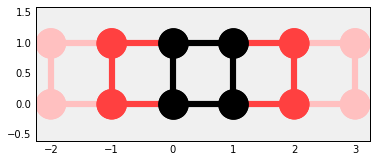

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import kwant
import numpy as np
import current
import test_system as t
import ipyparallel as ipp
import pandas as pd
client = ipp.Client()
# Here should be the path, where CLUSTER nodes actually see source files
solver = current.Solver(client, '/home/bnijholt/Dropbox/Work/nanowire_current/')
W=2; L=2
delta=0.01
T=0.5*delta
ms_params = (W, L, delta)
syst = t.make_test_system(*ms_params)
kwant.plot(syst);
solver.prepare_system(t.make_test_system, ms_params)

2040/2040 tasks finished after   18 s
done
Error = 0.000325332995129


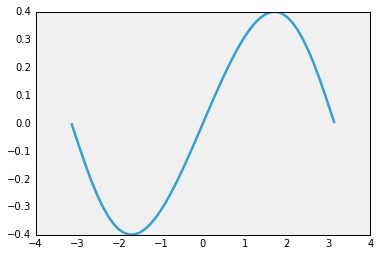

In [71]:
T=delta*0.5
args_list=[[0.]]
nmatsfreq = 40
phases = np.linspace(-np.pi, np.pi, 51)

nullgf_data = solver.matsubara_nullgf_args_map(T, list(range(nmatsfreq)), args_list)
gf_data = solver.gf_from_nullgf_data(nullgf_data, phases)
curr_data, error = solver.current_from_gf_data(gf_data)
print("Error =", error) # Generally error of order 0.01 is Ok for visual data

plt.figure()
plt.plot(curr_data["phases"][0], curr_data["currents"][0]/delta/W)
plt.show()

# Another way of calculating the super current

In [97]:
from types import SimpleNamespace
import kwant
import numpy as np
import holoviews as hv
hv.notebook_extension()

s0 = np.array([[1., 0.], [0., 1.]])
sx = np.array([[0., 1.], [1., 0.]])
sy = np.array([[0., -1j], [1j, 0.]])
sz = np.array([[1., 0.], [0., -1.]])

onsite = lambda site, p: -p.mu * sz
onsite_lead = lambda site, p: -p.mu * sz + p.delta * sx
hops = lambda site1, site2, p: -p.t * sz

def make_test_system(W, L):
    lat = kwant.lattice.square()
    syst = kwant.Builder()
    range_w = range(W//2 - W + 1, W//2 + 1)
    range_l = range(L//2 - L + 1, L//2 + 1)
    syst[(lat(x, y) for x in range_l for y in range_w)] = onsite
    syst[lat.neighbors()] = hops

    l_cut = [lat(0, y) for y in range_w]
    r_cut = [lat(1, y) for y in range_w]

    num_orbs = 2
    dim = num_orbs * len(l_cut) * len(r_cut)
    vlead = kwant.builder.SelfEnergyLead(lambda energy, args: np.zeros((dim, dim)), r_cut + l_cut)
    syst.leads.append(vlead)
    
    lead = kwant.Builder(kwant.TranslationalSymmetry((-1, 0)))
    lead[(lat(0, y) for y in range_w)] = onsite_lead
    lead[lat.neighbors()] = hops
    syst.attach_lead(lead)
    syst.attach_lead(lead.reversed())
    syst = syst.finalized()
    
    r_cut_sites = [syst.sites.index(site) for site in r_cut]
    l_cut_sites = [syst.sites.index(site) for site in l_cut]
    
    def hopping(syst, args=()):
        return syst.hamiltonian_submatrix(args=args,
                                          to_sites=l_cut_sites,
                                          from_sites=r_cut_sites)[::2, ::2]
    return syst, hopping


[0, 1] [3, 2]


b':Curve   [phase]   ($I$)'
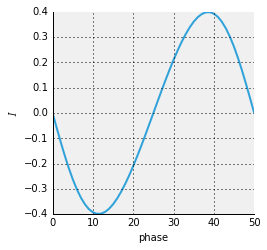

In [101]:
def matsubara_frequency(T, n):
    return (2*n + 1) * np.pi * T * 1j


def null_H(syst, T, n):
    en = matsubara_frequency(T, n)
    gf = kwant.greens_function(syst, en, [p], [0], [0], check_hermiticity=False)
    return np.linalg.inv(gf.data[::2, ::2])


def gf_from_H_0(H_0, t):
    H = np.copy(H_0)
    dim = t.shape[0]
    H[:dim, dim:] -= t.T.conj()
    H[dim:, :dim] -= t
    return np.linalg.inv(H)


def current_from_H_0(T, H_0s, H12, phase):
    t = H12 * np.exp(1j * phase)
    I = 0
    for H_0 in H_0s:
        gf = gf_from_H_0(H_0, t - H12)
        dim = t.shape[0]
        H12G21 = t.T.conj() @ gf[dim:, :dim]
        H21G12 = t @ gf[:dim, dim:]
        I += -4 * T * (np.trace(H21G12) - np.trace(H12G21)).imag
    return I

W = 2
L = 2
delta = 0.01
T = 0.5 * delta
matsfreqs = 20

syst, hopping = make_test_system(W, L)
p = SimpleNamespace(mu=0., t=1., delta=delta)

H12 = hopping(syst, [p])
phases = np.linspace(-np.pi, np.pi, 51)
H_0s = [null_H(syst, T, n) for n in range(matsfreqs)]
I = np.array([current_from_H_0(T, H_0s, H12, phase) for phase in phases])
hv.Curve(I/delta/W, kdims=['phase'], vdims=['$I$'])